# Projeto: Rossmann Stores Sales


# 0.0 IMPORTS

In [213]:
import pandas as pd
import inflection #Using underscore mode
import math 
import numpy as np
import xgboost as xgb
import seaborn as sns
import datetime as datetime

from tabulate              import tabulate
from matplotlib            import pyplot as plt
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from scipy                 import stats as ss #chi quadrado 4.3
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


0.1 HELPER FUNCTIONS

In [2]:
# DEF para V de Cramer
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# DEF para modelo de média
def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame( {
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

In [3]:
plt.rcParams["figure.figsize"] = (20,10) # Setar o tamanho padrão das figuras/gráficos

0.2. LOADING DATA

In [4]:
df_sales_raw = pd.read_csv( "/Users/joaofmoura/Desktop/Aulinhas/Projetos/rossmann-store-sales/train.csv", low_memory=False)
df_store_raw = pd.read_csv( "/Users/joaofmoura/Desktop/Aulinhas/Projetos/rossmann-store-sales/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

# 1.1. Rename Columns

In [6]:
cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#Renane
df1.columns = cols_new

# 1.2. Data Dimensions

In [7]:
print ("Number of Rows:{}" .format( df1.shape[0]))
print ("Number of Columns:{}" .format( df1.shape[1]))

Number of Rows:1017209
Number of Columns:18


# 1.3. Data Types

In [8]:
df1["date"] = pd.to_datetime (df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5. Fillout NA 

### Por que preencher os NA - Pois o modelo não entende os dados faltantes e para tentar aproveitar a maior quantidade possível de dados para que o algoritmo entenda o padrão. 

In [10]:
#competition_distance - Usei 200.000 que é um valor maior que o máximo.   (lambda x = fx)
df1 ["competition_distance"] = df1 ["competition_distance"].apply (lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month - The store has no nearby competitor or we don't have the date when the competitor's store was opened. (To solve the NA I replace it with the month value on that line)
df1 ["competition_open_since_month"] = df1.apply(lambda x: x["date"].month if math.isnan ( x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

#competition_open_since_year - The store has no nearby competitor or we don't have the date when the competitor's store was opened.  (To solve the NA I replace it with the year value on that line)    
df1 ["competition_open_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan ( x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)
                          
#promo2_since_week - The NAs are because the store didn't participate the promotion, so I'm going to replace the NAs with the date value on each line.
df1 ["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan ( x["promo2_since_week"]) else x["promo2_since_week"], axis=1)        

#promo2_since_year - The NAs are because the store didn't participate in the promotion, so I'm going to replace the NAs with the date value on each line. 
df1 ["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan ( x["promo2_since_year"]) else x["promo2_since_year"], axis=1)    

#promo_interval - slip the list, if the interval is on the list, the promo2 is activate    
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True)

df1["month_map"] = df1["date"].dt.month.map( month_map)

df1 ["is_promo"] = df1[["promo_interval", "month_map"]].apply( lambda x: 0 if x["promo_interval"] == 0 else 1 if x ["month_map"] in x ["promo_interval"].split (",") else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

# 1.6. Change Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
# competition_open_since_month - should be a int because its the month number ( 1 - january)
df1 ["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)

#competition_open_since_year - should be a int because the year is represented by numbers 
df1 ["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

#promo2_since_week - should be int because week is a number
df1 ["promo2_since_week"] = df1["promo2_since_week"].astype(int)

#promo2_since_year - should be int because year is a number
df1 ["promo2_since_year"] = df1["promo2_since_year"].astype(int)

# 1.7. Descriptive Statistical

Gain business knowledge and detect some errors through dispersion metrics (which say if I am very concentrated near the mean or not - variance, standard deviation, range) and central tendency (mean and median). 

- Skew: deformation of my distribution according to normal (left positive and right negative);
- Kurtosis: data concentration;
- Standard deviation: distance of points from the mean;
- Range: difference between minimum and maximum;

- num_attributes: numerical collumns;
- cat_attributes: categortical collumns (strings).

In [14]:
num_attributes = df1.select_dtypes( include =["int64", "float64"])
cat_attributes = df1.select_dtypes( exclude =["int64", "float64", "datetime64[ns]"])

# 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
round(m,2)

# Analisando a coluna de vendas (variavél resposta):
    # Média: Quantidade média de vendas nas lojas. (tendência central)
    # Desvio Padrão: A dispersão entre os valores referente a média.()
    # Min: O valor mínimo.
    # 50% Mediana:
    # Máx: O valor máximo. 

# Calcular dispersão dos dados (coeficiente de variação) = std / mean 
    # Se valor prox. 1 - dados muitos dispersos 
    # Se valor prox. 0 - dados condensados

# Premissas de Machine Learning.
    # Dados são independentes;
    # A disribuição da variável resposta é normal - distribuição simétrica em relação à média (Skew prox. de zero). 

# Skew: valor próximo de zero mostra que não está pegando nenhum viés, sendo a distribuição simétrica = melhor meus resultados.
# Kutosis: Quantos dados tem muito distante do desvio padrão (calda longa)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.43,558.0,321.91,-0.00,-1.20
1,day_of_week,1.0,7.0,6.0,4.00,4.0,2.00,0.00,-1.25
2,sales,0.0,41551.0,41551.0,5773.82,5744.0,3849.92,0.64,1.78
3,customers,0.0,7388.0,7388.0,633.15,609.0,464.41,1.60,7.09
4,open,0.0,1.0,1.0,0.83,1.0,0.38,-1.76,1.09
5,promo,0.0,1.0,1.0,0.38,0.0,0.49,0.49,-1.76
6,school_holiday,0.0,1.0,1.0,0.18,0.0,0.38,1.68,0.82
7,competition_distance,20.0,200000.0,199980.0,5935.44,2330.0,12547.65,10.24,147.79
8,competition_open_since_month,1.0,12.0,11.0,6.79,7.0,3.31,-0.04,-1.23
9,competition_open_since_year,1900.0,2015.0,115.0,2010.32,2012.0,5.52,-7.24,124.07


/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

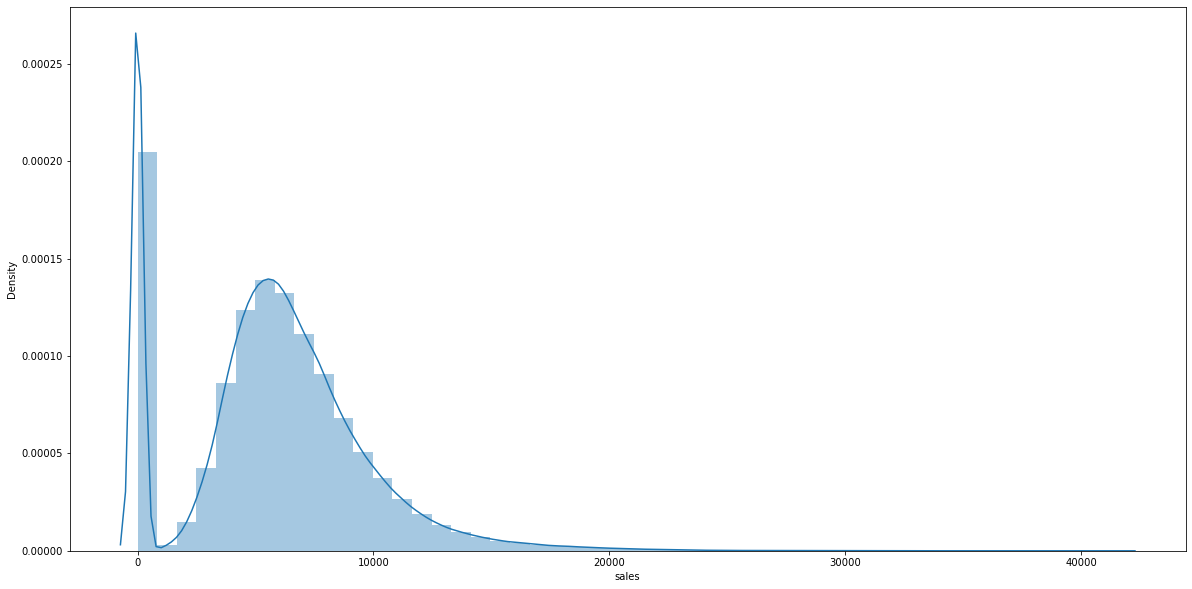

In [16]:
sns.distplot(df1["sales"])

/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

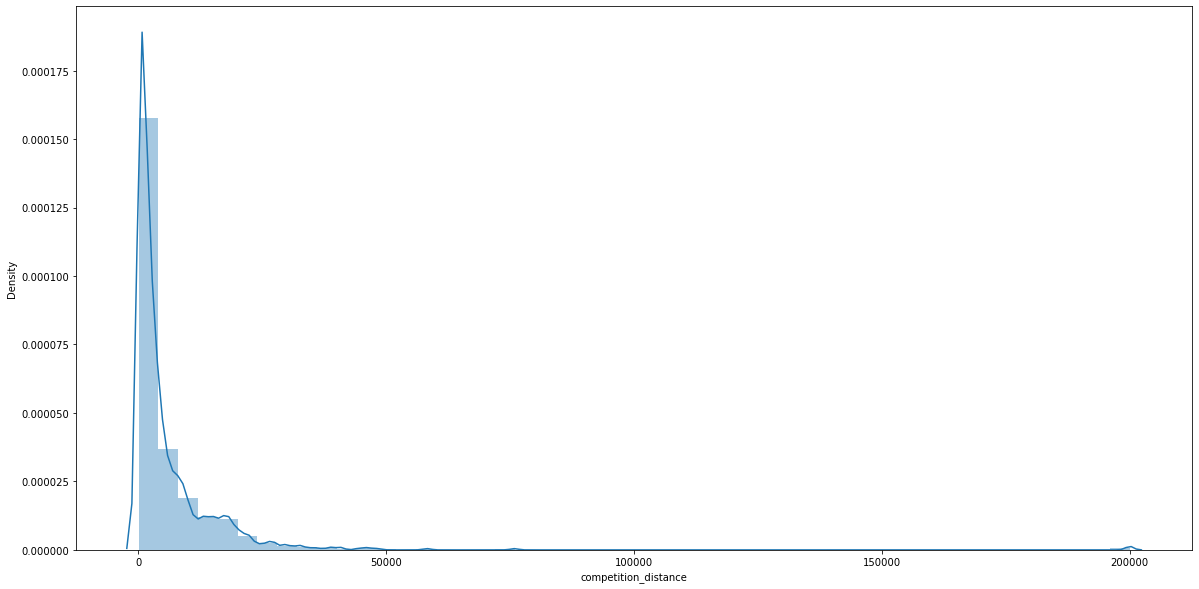

In [17]:
sns.distplot(df1["competition_distance"])

# Analysing "competition_distance" - Os competidores estão muito próximos, por isso que tem um pico muito alto próximo ao zero, lembrando uma distribuição de Poisson 

# 1.7.1 Atributos Categóricos

In [18]:
cat_attributes.apply (lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

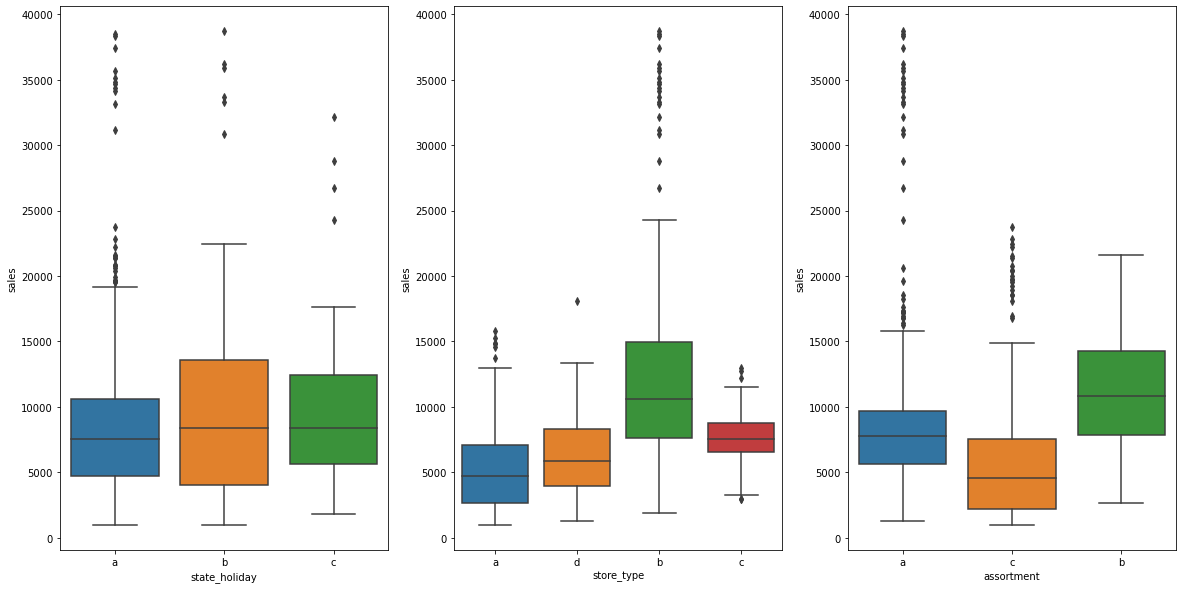

In [19]:
# x=O nome da categoria / y=O que eu quero medir / data=O que você quer mostrar

aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"]>0)] #Preciso fazer esse filtro pois as dimnesões das variáveis estão muito diferentes para excluir os dias que as lojas estão fechadas.

plt.subplot( 1, 3, 1)
sns.boxplot( x="state_holiday", y="sales", data=aux1)

plt.subplot( 1, 3, 2)
sns.boxplot( x="store_type", y="sales", data=aux1)

plt.subplot( 1, 3, 3)
sns.boxplot( x="assortment", y="sales", data=aux1)

# Explicando o Boxplot: Gráfico para análise comparativa 

## Abaixo do Traço inferior - Outliers: q1-1,5.i
## Quartil 25%: q1
## Quartil 50% - Mediana: Representada pela linha do meio 
## Quartil 75%: q3
## Quartil 100%: Valor máximo
## Acima do Traço superior - Outliers: q3+1,5.i
### i = q3-q1 

###State_holiday - b e c tem mediana muito proximas. b tem um equilibrio entre os quartils. 
###Store_type - loja b tem muito mais outliers que as outras e a mediana de vendas é maior. na loja c tem dados poucos volumosos perto da mediana
###Assortments - b tem um mix de produtos bem maior que as outras, o a tem muito mais outliers. 

Update do Progresso do Projeto do Rossaman:
- Questão de Negócio: Entendi que precisava ser feito uma previsão de vendas por lojas nas próximas 6 semanas. 
- Entendimento do Negócio: A dificiculdade do CEO encontrar a quantidade de dinheiro que irá ser investido na reforma das lojas. 
- Limpeza dos daods - Garantir que os tipos de dados estão corretos, garantir que os NAs foram substituidos baseados em critérios e entender a dimensão dos dados. 

Exploração dos dados: 
- Criar as variaveis
- lista de hipoteses 
- Validar as hipóteses

Feature Engineering 

- Porque fazer? Ter as variáveis disponíveis para estudo durante a Analise Exploratória de Dados. 

# 2.0. FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

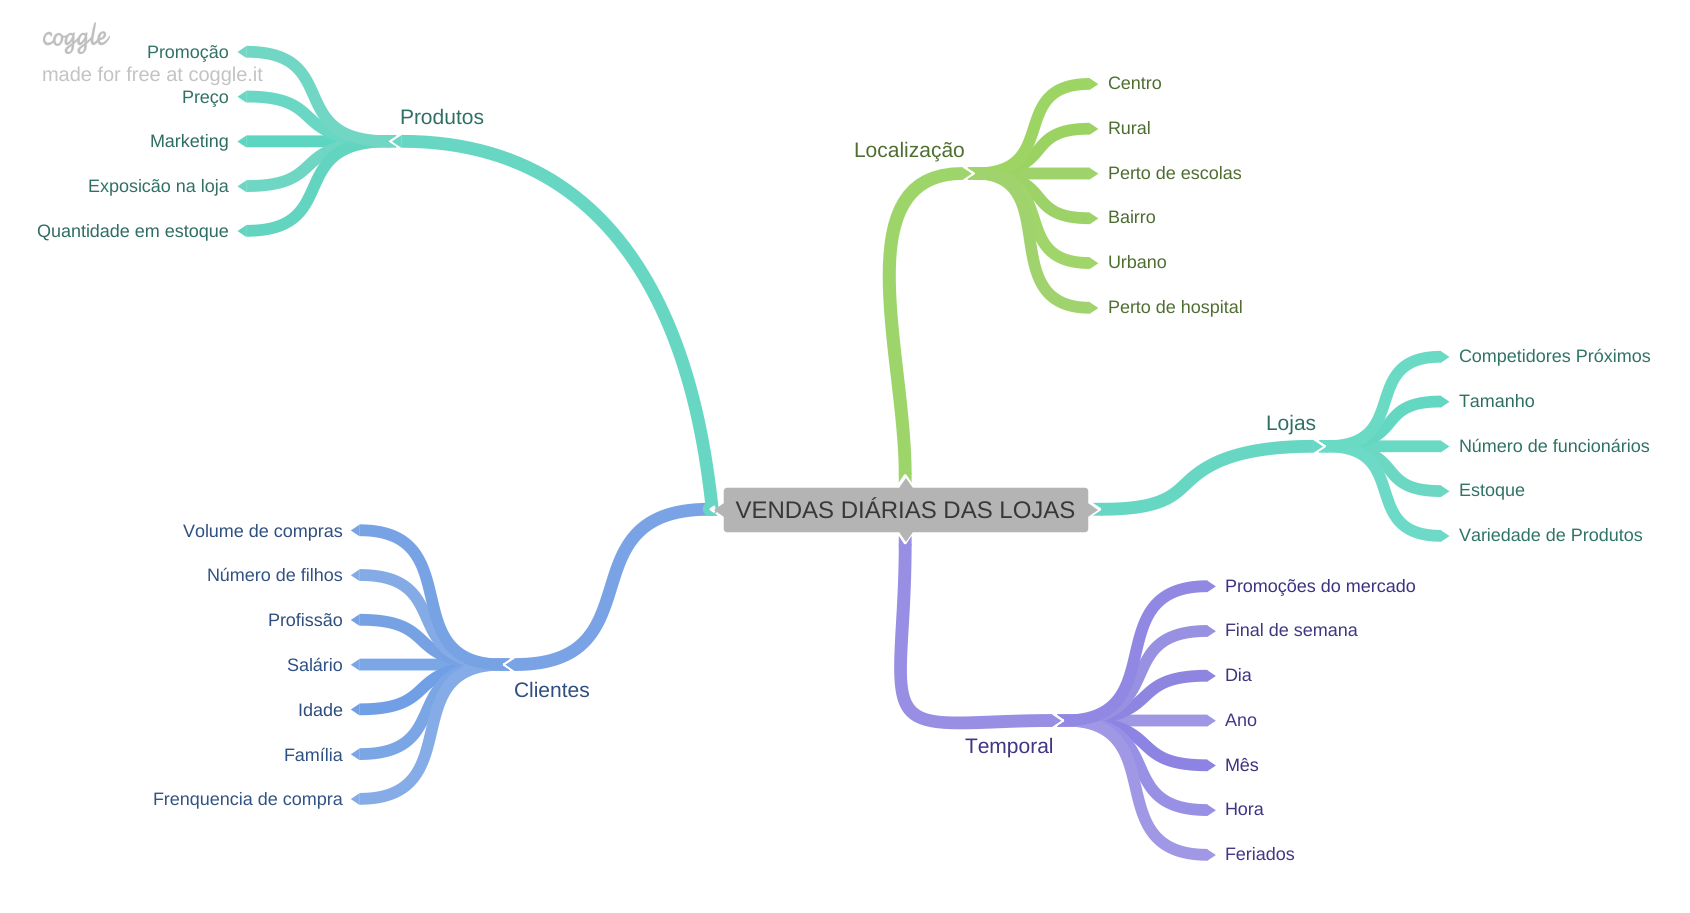

In [21]:
Image("/Users/joaofmoura/Desktop/Aulinhas/Projetos/rossmann-store-sales/img/MindMapHypotesis.png")

# 2.2. Criação das Hipóteses

## 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais;

**2.**  Lojas com maior capacidade de estoque deveriam vender mais;

**3.**  Lojas com maior porte deveriam vender mais;

**4.**  Lojas com maior variedade de produtos deveriam vender mais;

**5.**  Lojas com competidores mais próximos deveriam vender menos;

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


## 2.2.2. Hipoteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais;

**2.** Lojas com maior exposição de produto deveriam vender mais;

**3.** Lojas com produtos com preço menor deveriam vender mais;

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais;

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**7.** Lojas com mais dias de promoção deveriam vender mais;

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

## 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**2.** Lojas deveriam vender mais ao longo dos anos;

**3.** Lojas deveriam vender mais no segundo semestre do ano;

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**5.** Lojas deveriam vender menos aos finais de semana;

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2.4. Lista Final de Hipóteses

**1.** Lojas com maior variedade de produtos deveriam vender mais;
##### Eu tenho os tipos de produtos.

**2.** Lojas com competidores mais próximos deveriam vender menos;
##### Eu tenho informações dos competidores.

**3.** Lojas com competidores à mais tempo deveriam vendem mais;
##### Eu tenho informações dos competidores.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais;
##### Eu tenho informações se a promoção está ativa.

**5.** Lojas com mais dias de promoção deveriam vender mais;
##### Eu tenho informações se a promoção está ativa.

**6.** Lojas com mais promoções consecutivas deveriam vender mais;
##### Eu tenho informações se a promoção está ativa.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais;
##### Eu tenho as informações dos feriados.

**8.** Lojas deveriam vender mais ao longo dos anos;
##### Através da variavel "date" eu consigo criar uma variável ano e obter informações.

**9.** Lojas deveriam vender mais no segundo semestre do ano;
##### Consio extrair os semestres através da variável "date".

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês;
##### Consigo extrair o dia e o mês através da variável "date".

**11.** Lojas deveriam vender menos aos finais de semana;
##### Consio extrair os semestres através da variável "date".

**12.** Lojas deveriam vender menos durante os feriados escolares.
##### Eu tenho as informações dos feriados.

# 2.3. FEATURE ENGINEERING

In [22]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

#week of year
df2["week_of_year"] = df2["date"].dt.weekofyear

#year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")


#competition since
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis =1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) /30).apply(lambda x: x.days).astype(int)

#promo since
df2["promo_since"] = df2["promo2_since_year"].astype( str ) + "-" + df2["promo2_since_week"].astype( str )
df2["promo_since"] = df2["promo_since"].apply( lambda x: datetime.datetime.strptime( x + "-1", "%Y-%W-%w" ) - datetime.timedelta( days=7 ) )
df2["promo_time_week"] = ( ( df2["date"] - df2["promo_since"] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2["assortment"] = df2["assortment"].apply( lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended" )

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply( lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day" )


/var/folders/53/4pxfn2gs1g55x_fdmzh2w0tw0000gn/T/ipykernel_25271/881403481.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtagem das Linhas


In [26]:
#Restrições do negócio - dias que a loja estão fechadas e quando a loja não vende.
df3 = df3[(df3 ["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Seleção das Colunas

In [27]:
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop( cols_drop, axis=1) #axis=0 Linhas / axis=1 Colunas

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [29]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Análise da variável Resposta

/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

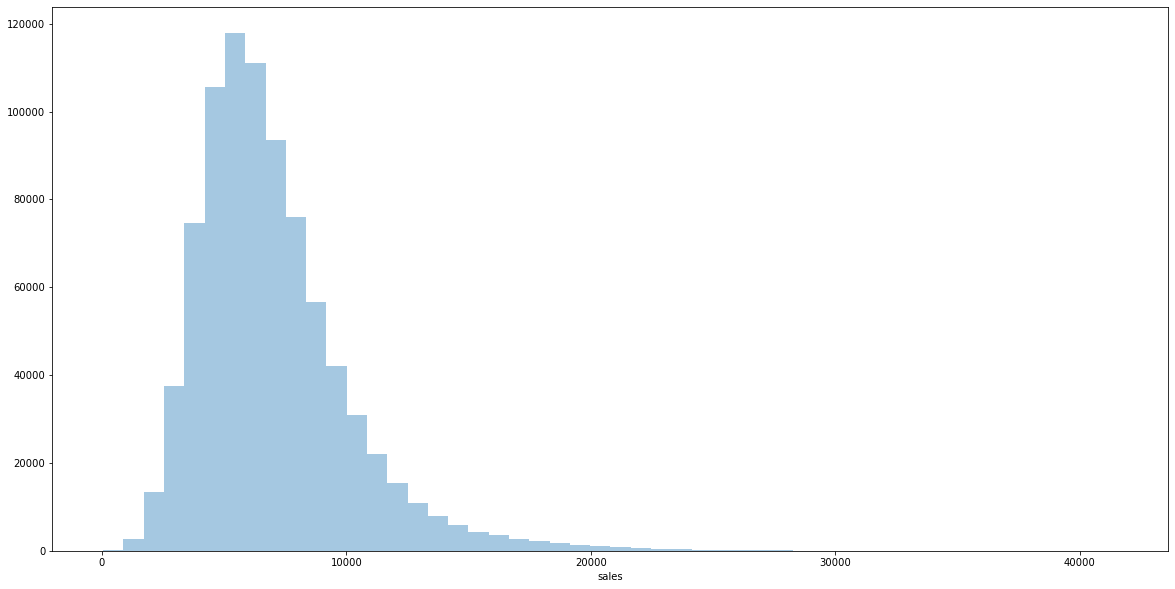

In [30]:
sns.distplot(df4["sales"], kde=False)

# skew positiva, próxima de uma normal. (KDE = False plota somente o histograma)

### 4.1.2. Análise das variáveis numéricas

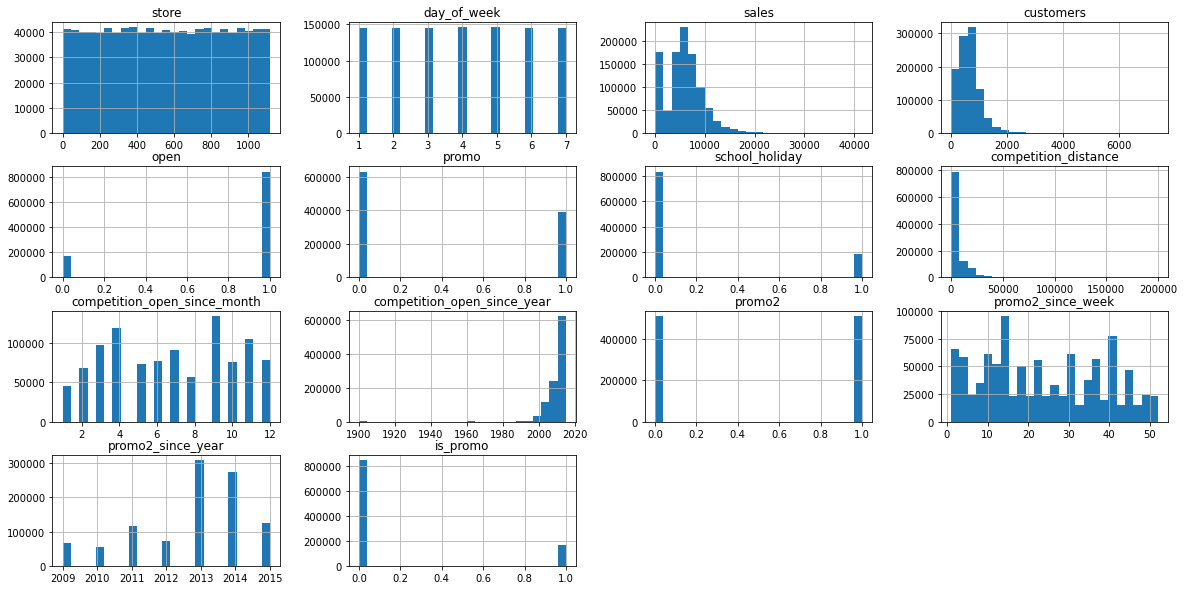

In [31]:
num_attributes.hist(bins = 25); # bins: caixa de dados

# Store:
# day_of_week: as vendas são iguais todos os dias da semana;
# sales:
# customers:
# open:
# promo:
# school_holiday: tenho mais vendas quando não é feriado escolar;
# competition_distance: competidores estão muito próximos;
# competition_open_since_month: 
# competition_open_since_year:
# promo2: 
# promo2_since_week:
# promo2_since_year:
# is_promo: tenho mais vendas quando não tenho promoção.

### 4.1.3. Análise das variáveis categóricas

/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

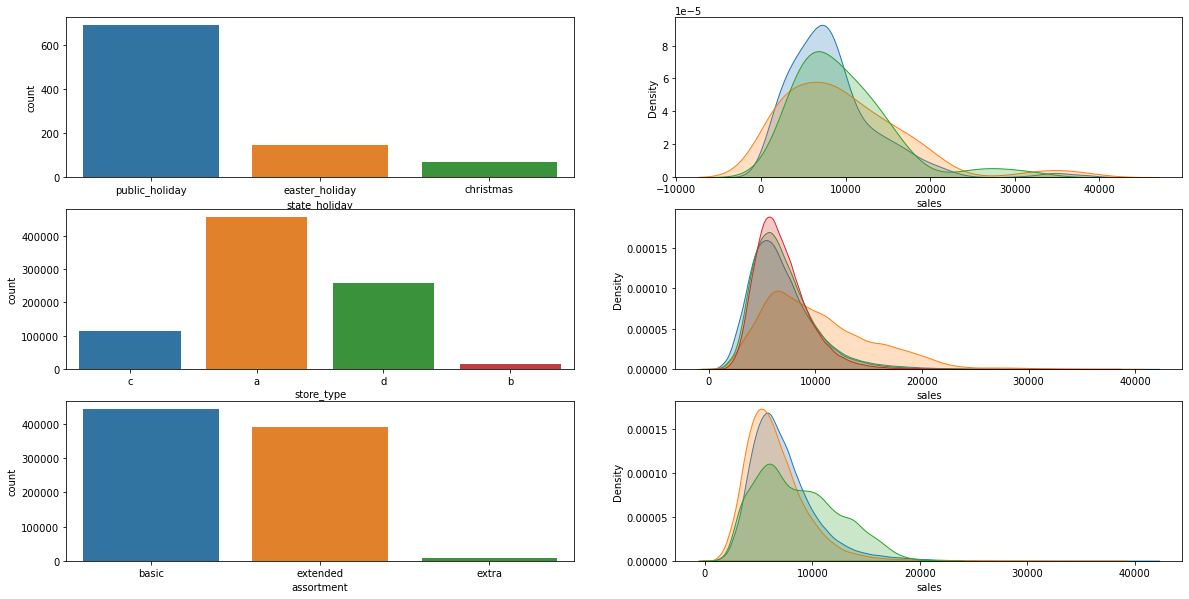

In [32]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot( a["state_holiday"] );

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True );
sns.kdeplot( df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True );
sns.kdeplot( df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4["store_type"] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4["store_type"] == "a"]["sales"], label="a", shade=True );
sns.kdeplot( df4[df4["store_type"] == "b"]["sales"], label="b", shade=True );
sns.kdeplot( df4[df4["store_type"] == "c"]["sales"], label="c", shade=True );
sns.kdeplot( df4[df4["store_type"] == "d"]["sales"], label="d", shade=True );

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4["assortment"] );

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True );
sns.kdeplot( df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True );
sns.kdeplot( df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True );

## 4.2. Análise Bivariada

### **H1.** Lojas com maior variedade de produtos deveriam vender mais.
### **ERRADO** Lojas com mais variedades de produtos, vendem menos!

<AxesSubplot:xlabel='year_week'>

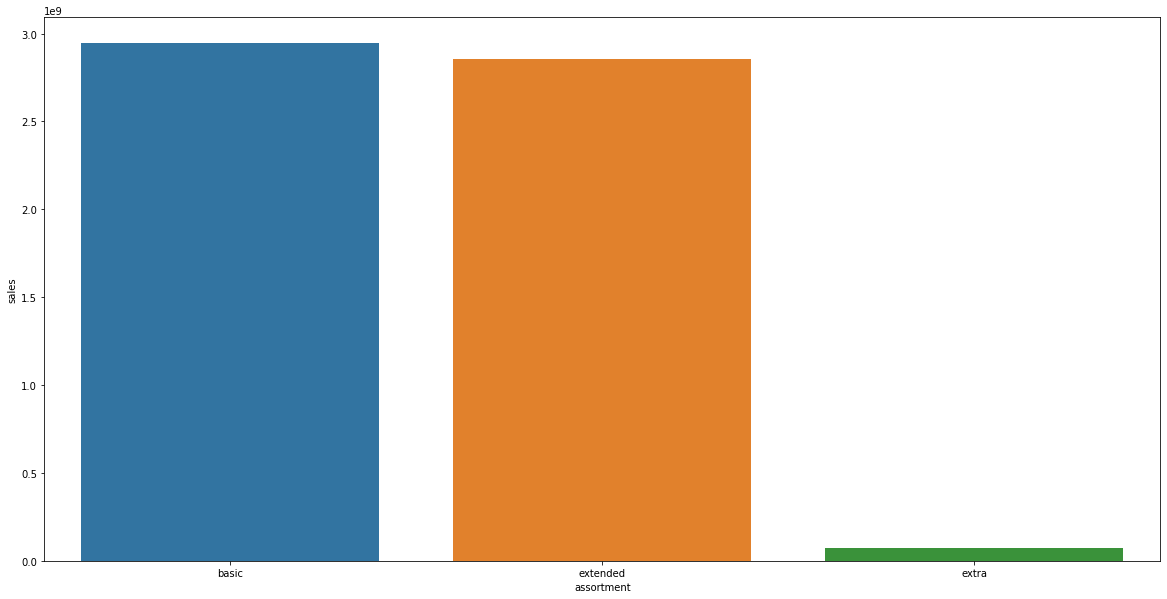

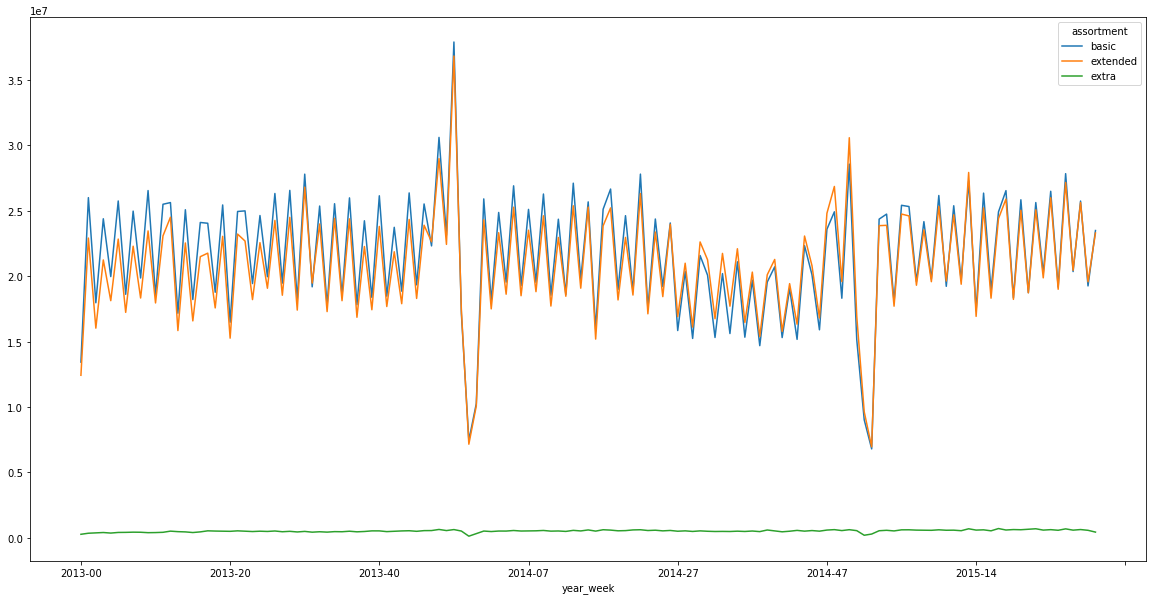

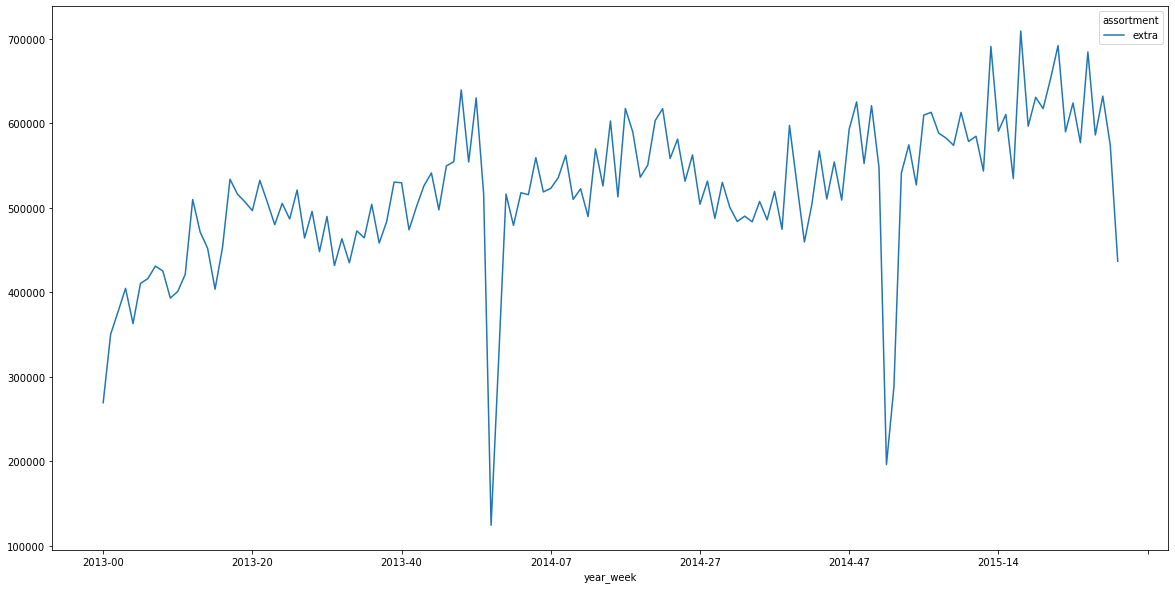

In [33]:
aux1 = df4[["assortment", "sales"]].groupby("assortment").sum().reset_index()
sns.barplot( x="assortment", y="sales", data=aux1);

aux2 = df4[["year_week", "assortment", "sales"]].groupby(["year_week", "assortment"]).sum().reset_index()
aux2.pivot( index="year_week", columns="assortment", values="sales").plot()

aux3 = aux2[aux2["assortment"] == "extra"]
aux3.pivot( index="year_week", columns="assortment", values="sales").plot()


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
### **ERRADO** Lojas com mais competidores mais próximos, vendem mais!

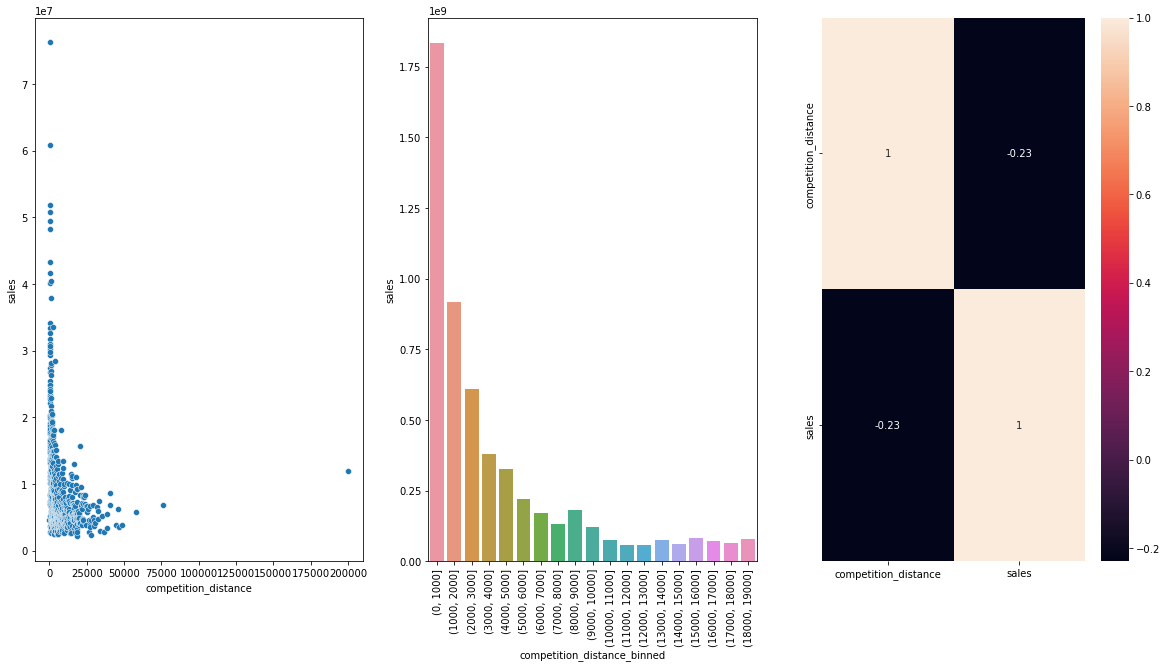

In [34]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

plt.subplot(1, 3, 1) # Os competidores estão geralmente mais próximos
sns.scatterplot(x = "competition_distance", y="sales", data=aux1);

plt.subplot(1, 3, 2) #Quanto mais próximo o competidor, mais vendas. 
bins = list(np.arange( 0, 20000, 1000)) 
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()
sns.barplot (x="competition_distance_binned", y="sales", data=aux2);
plt.xticks(rotation =90)

plt.subplot(1, 3, 3) #Quanto mais distante o meu competidor está, menor a venda. 
x = sns.heatmap(aux1.corr(method="pearson"), annot = True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
### **ERRADO** Lojas com mais competidores a mais tempo, vendem menos!

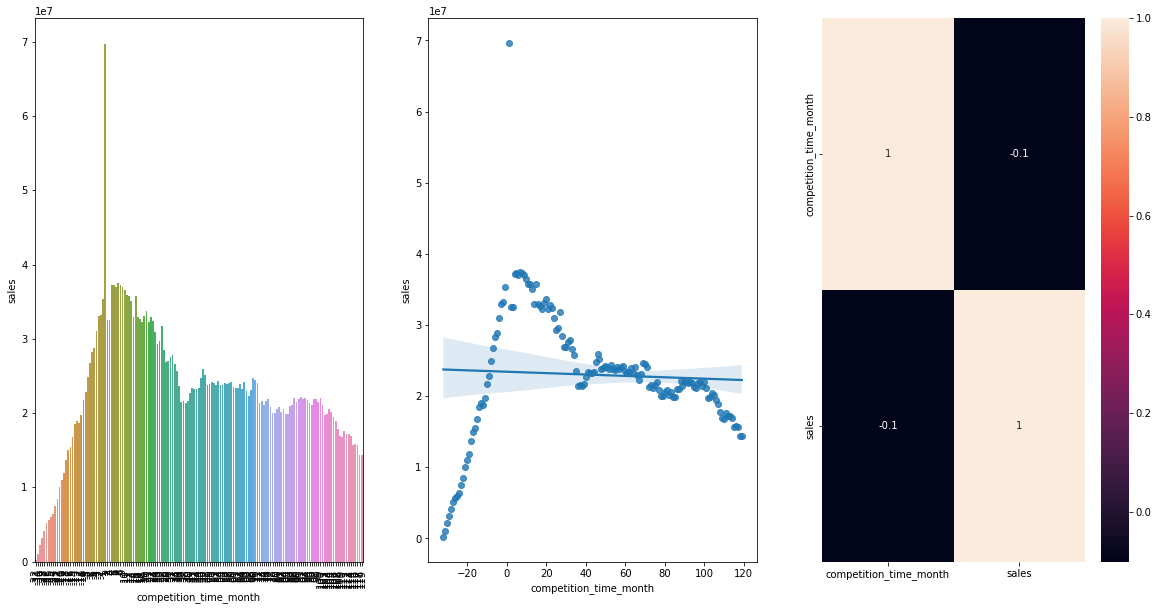

In [35]:
plt.subplot(1, 3, 1)
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").sum().reset_index()
aux2 = aux1[(aux1["competition_time_month"]<120) & (aux1["competition_time_month"]!=0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks(rotation =90);

plt.subplot(1, 3, 2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);

plt.subplot(1, 3, 3) #relação muito fraca
x = sns.heatmap(aux1.corr(method="pearson"), annot = True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
### **ERRADO** Lojas vendem mais até um certo tempo de promoção depois as vendas começam a cair!

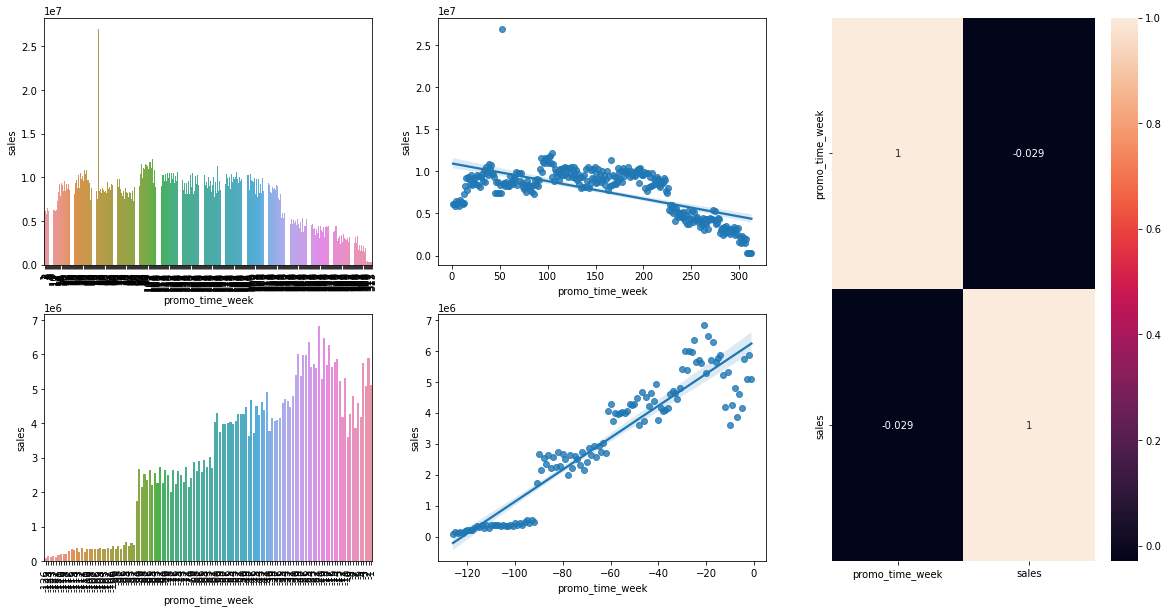

In [36]:
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1["promo_time_week"]>0] # promoção extendida
sns.barplot(x="promo_time_week", y="sales", data=aux2);
plt.xticks (rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1["promo_time_week"]<0] # promoção regular
sns.barplot(x="promo_time_week", y="sales", data=aux3);
plt.xticks (rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x="promo_time_week", y="sales", data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais;</s>
###### Hipótese parecida com a anterior.


### **H6.** Lojas com mais promoções consecutivas deveriam vender mais;
### **ERRADO** Lojas com mais promoões consecutivas, vendem menos!

In [37]:
df4[["promo", "promo2", "sales"]].groupby(["promo", "promo2"]).sum().reset_index()

#De acordo com os resultados, não vale muito participar da promoção extendiada (promo e promo2), o maior resultado de vendas é quando só participa da primeira promoção.

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


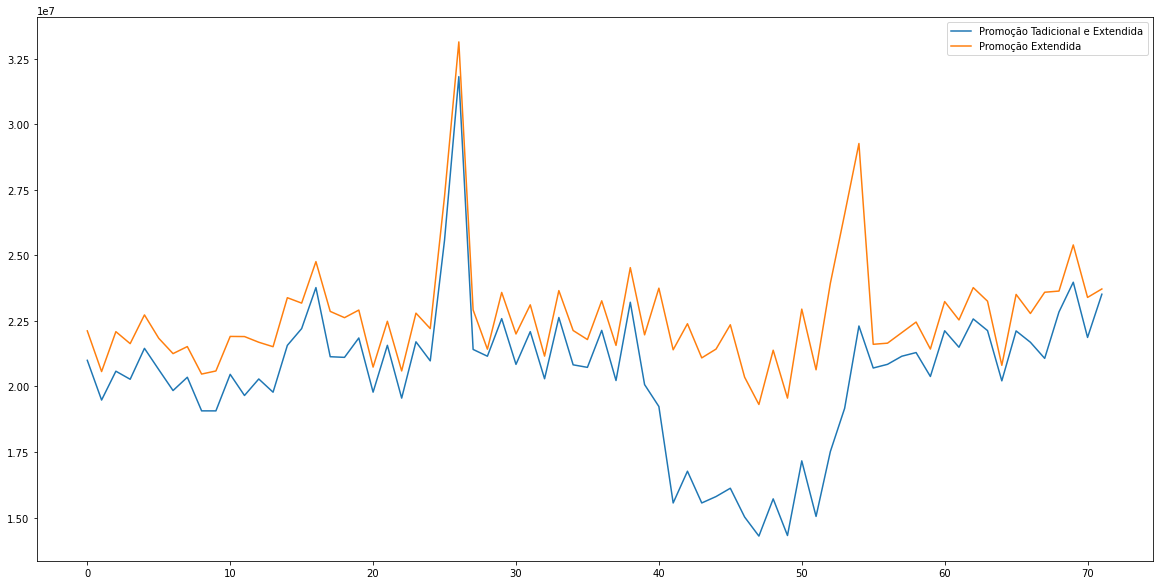

In [38]:
aux1 = df4[(df4["promo"]==1) & (df4["promo2"]==1)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4["promo"]==1) & (df4["promo2"]==0)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
aux2.plot(ax=ax) #Para plotar os dois gráficos no mesmo grid


ax.legend(labels=["Promoção Tadicional e Extendida", "Promoção Extendida"])

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais;
### **ERRADO** Lojas abertas durante o feriado do natal, vendem menos!

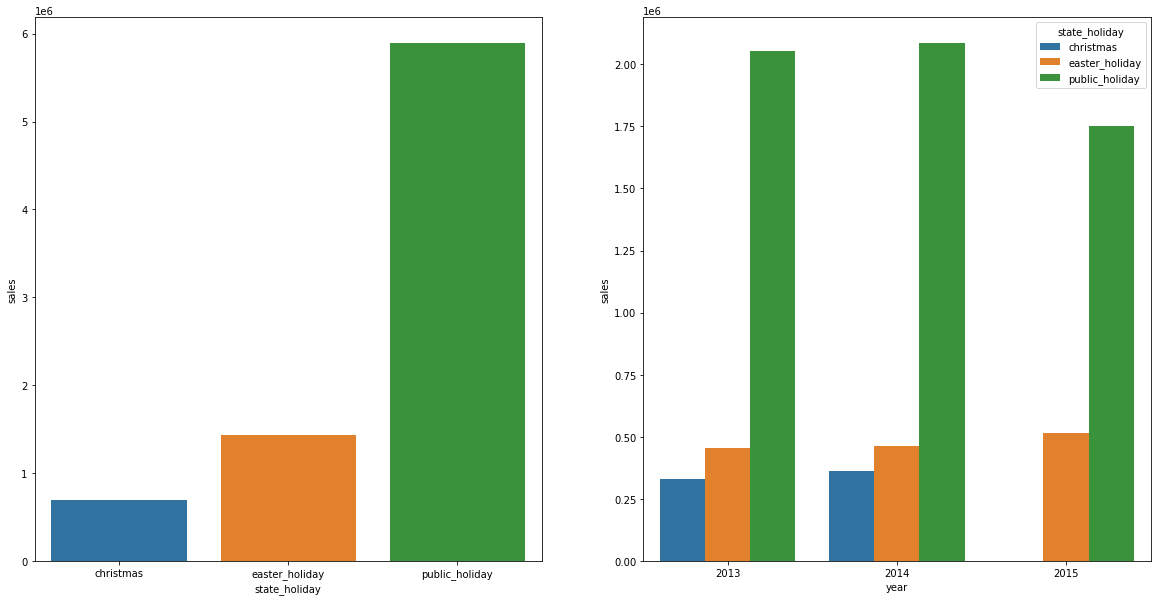

In [39]:
aux = df4[df4["state_holiday"] != "regular_day"]

plt.subplot( 1,2,1)
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);

plt.subplot( 1,2,2)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).sum().reset_index()
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);

#Dados vão até agosto, não temos dados de natal 2015

### **H8.** Lojas deveriam vender mais ao longo dos anos;
### **ERRADO** Lojas vendem menos ao longo dos anos!

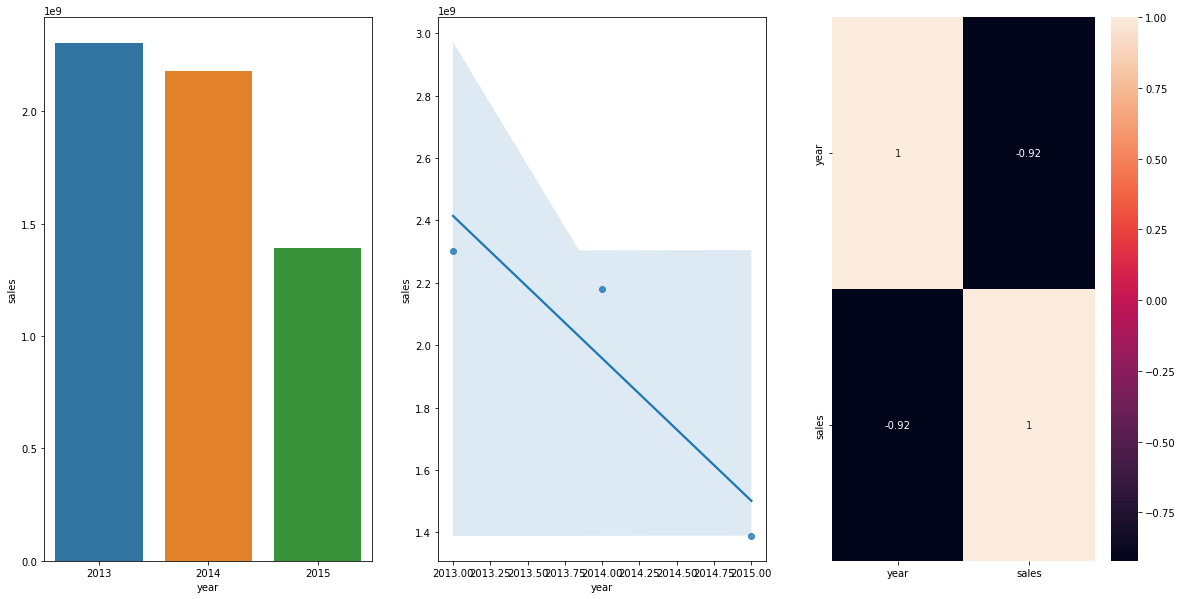

In [40]:
aux1 = df4[["year", "sales"]].groupby("year").sum().reset_index()

plt.subplot( 1,3,1) 
sns.barplot(x="year", y="sales", data=aux1);

plt.subplot( 1,3,2)
sns.regplot(x="year", y="sales", data=aux1);

plt.subplot( 1,3,3) #correlação muito alta, 2015 não é um ano completo 
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano;
### **ERRADO** Lojas vendem mais no primeiro semestre!

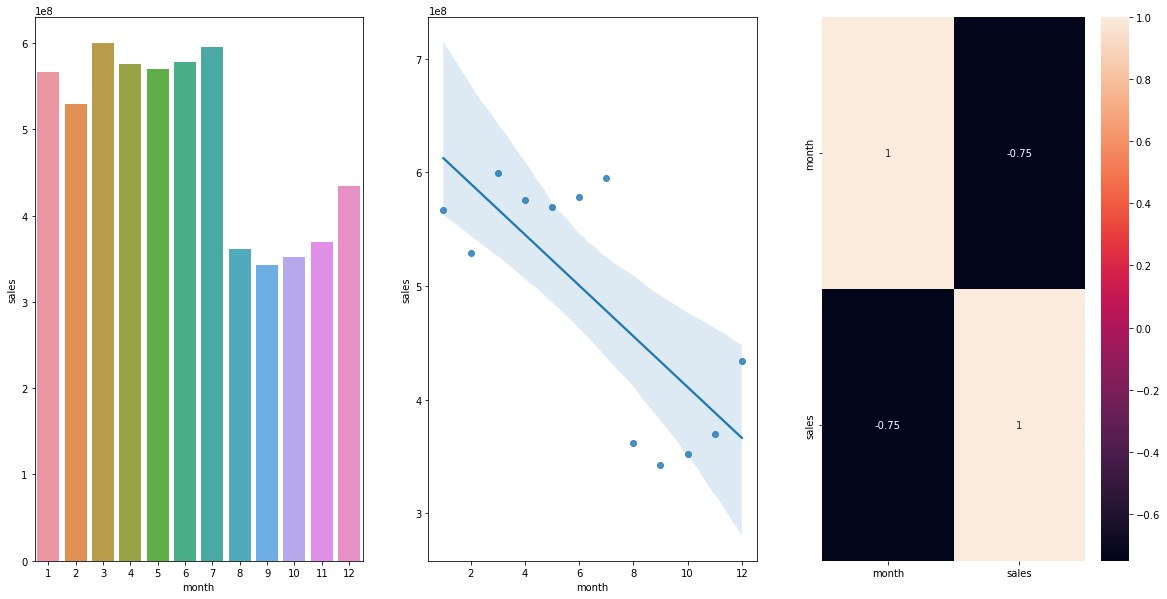

In [41]:
aux1 = df4[["month", "sales"]].groupby("month").sum().reset_index()

plt.subplot( 1,3,1) 
sns.barplot(x="month", y="sales", data=aux1);

plt.subplot( 1,3,2)
sns.regplot(x="month", y="sales", data=aux1);

plt.subplot( 1,3,3) #correlação muito alta, 2015 não é um ano completo 
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês;
### **VERDADE** Lojas vendem mais depois do dia 10.

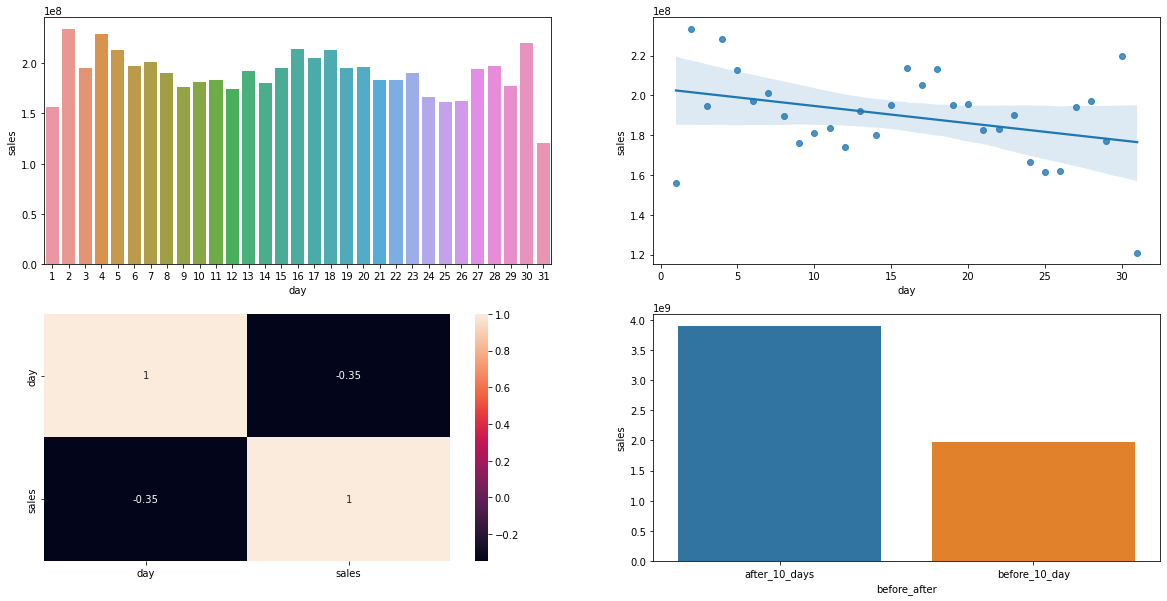

In [42]:
aux1 = df4[["day", "sales"]].groupby("day").sum().reset_index()

plt.subplot( 2,2,1) 
sns.barplot(x="day", y="sales", data=aux1);

plt.subplot( 2,2,2)
sns.regplot(x="day", y="sales", data=aux1);

plt.subplot( 2,2,3) #correlação muito alta, 2015 não é um ano completo 
sns.heatmap(aux1.corr(method="pearson"), annot=True);

plt.subplot( 2,2,4) 
aux1["before_after"] = aux1["day"].apply(lambda x: "before_10_day" if x <= 10 else "after_10_days")
aux2 = aux1[["before_after", "sales"]].groupby("before_after").sum().reset_index()
sns.barplot(x="before_after", y="sales", data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana;
### **VERDADE** Lojas vendem mais durante a semana!

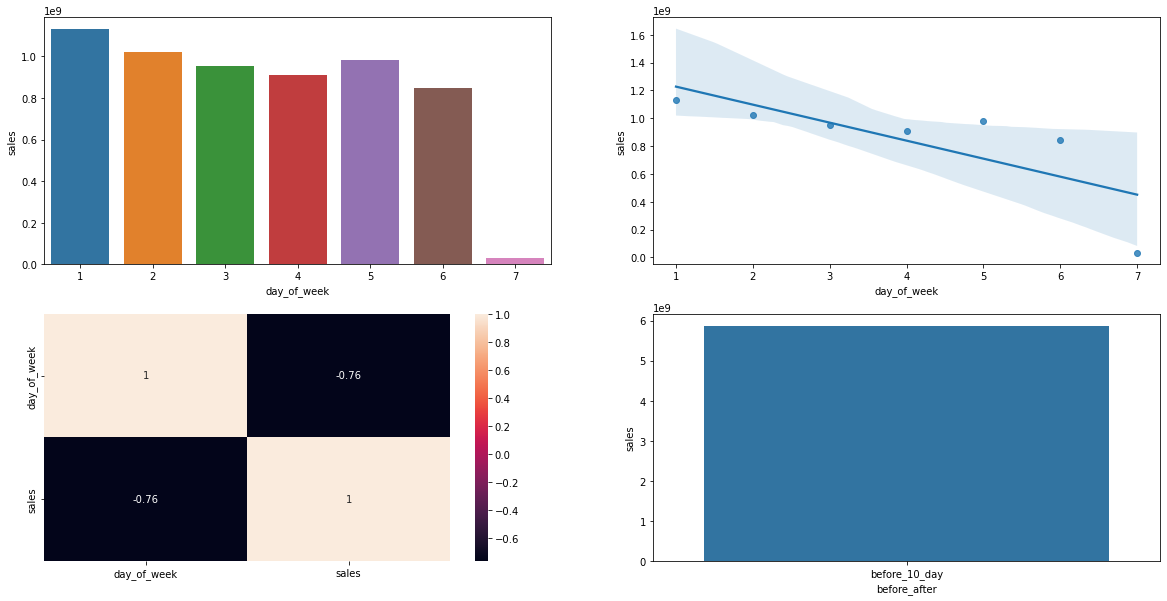

In [43]:
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").sum().reset_index()

plt.subplot( 2,2,1) 
sns.barplot(x="day_of_week", y="sales", data=aux1);

plt.subplot( 2,2,2)
sns.regplot(x="day_of_week", y="sales", data=aux1);

plt.subplot( 2,2,3) #correlação muito alta, 2015 não é um ano completo 
sns.heatmap(aux1.corr(method="pearson"), annot=True);

plt.subplot( 2,2,4) 
aux1["before_after"] = aux1["day_of_week"].apply(lambda x: "before_10_day" if x <= 10 else "after_10_days")
aux2 = aux1[["before_after", "sales"]].groupby("before_after").sum().reset_index()
sns.barplot(x="before_after", y="sales", data=aux2);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
### **VERDADE** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto!

<AxesSubplot:xlabel='month', ylabel='sales'>

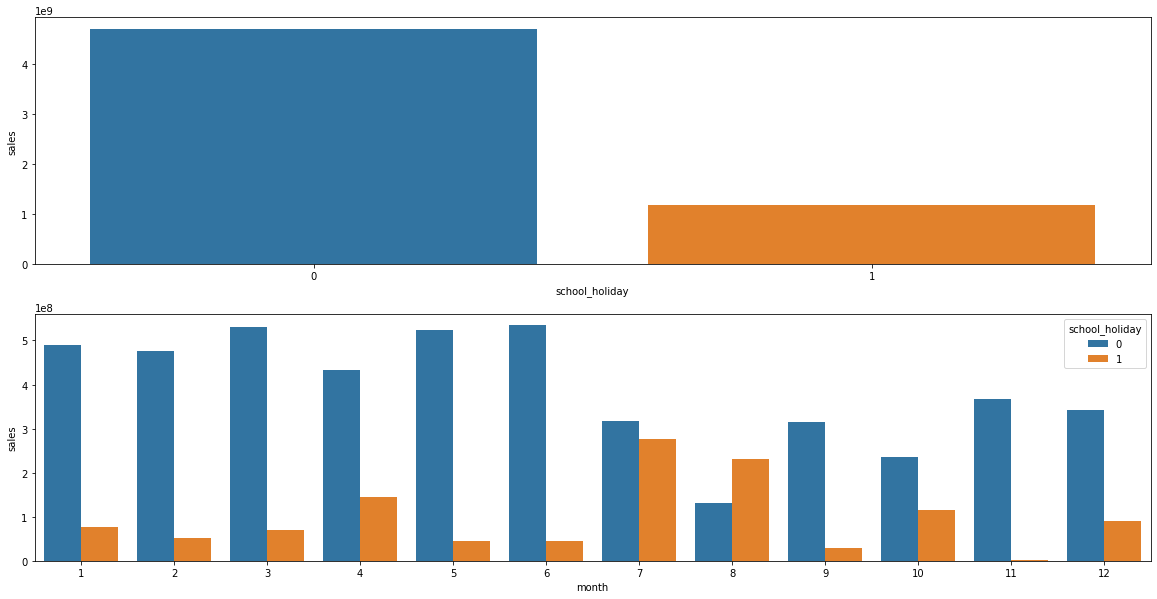

In [44]:
plt.subplot(2,1,1)
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").sum().reset_index()
sns.barplot(x="school_holiday", y="sales", data=aux1)

plt.subplot(2,1,2)
aux2 = df4[["month", "school_holiday", "sales"]].groupby(["month","school_holiday"]).sum().reset_index()
sns.barplot(x="month", y="sales",hue="school_holiday", data=aux2)

### 4.2.1. Resumo das Hipóteses

In [45]:
tab =[["Hipoteses", "Conclusao", "Relevancia"],
      ["H1", "Falsa", "Baixa"],  
      ["H2", "Falsa", "Media"],  
      ["H3", "Falsa", "Media"],
      ["H4", "Falsa", "Baixa"],
      ["H5", "-", "-"],
      ["H6", "Falsa", "Baixa"],
      ["H7", "Falsa", "Media"],
      ["H8", "Falsa", "Alta"],
      ["H9", "Falsa", "Alta"],
      ["H10", "Verdadeira", "Alta"],
      ["H11", "Verdadeira", "Alta"],
      ["H12", "Verdadeira", "Baixa"],
     ]  
print( tabulate( tab, headers="firstrow" ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

## 4.3.1. Atributos Numéricos

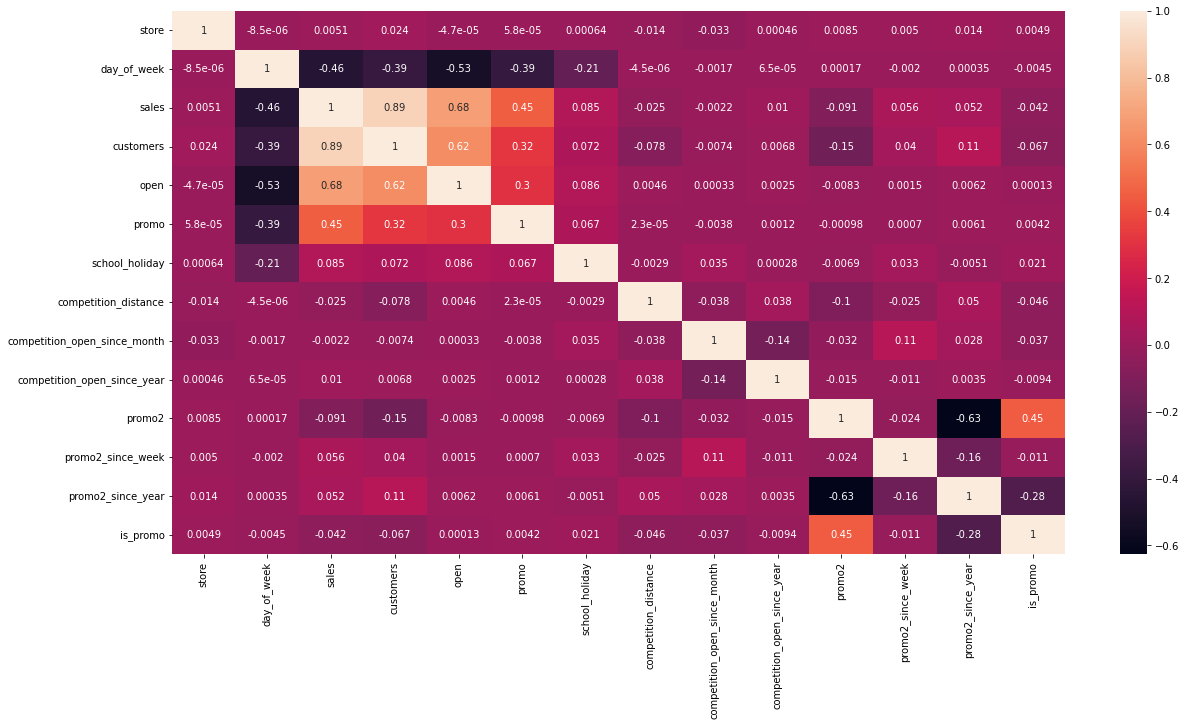

In [46]:
correlation = num_attributes.corr(method="pearson") #teste estatístico para calcular duas variáveis numéricas
sns.heatmap(correlation, annot=True);

# Quanto mais próximo da cor preto, maior a correlação negativa e da cor branca, maior a correlação negativa.

## 4.3.2. Atributos Categóricos

<AxesSubplot:>

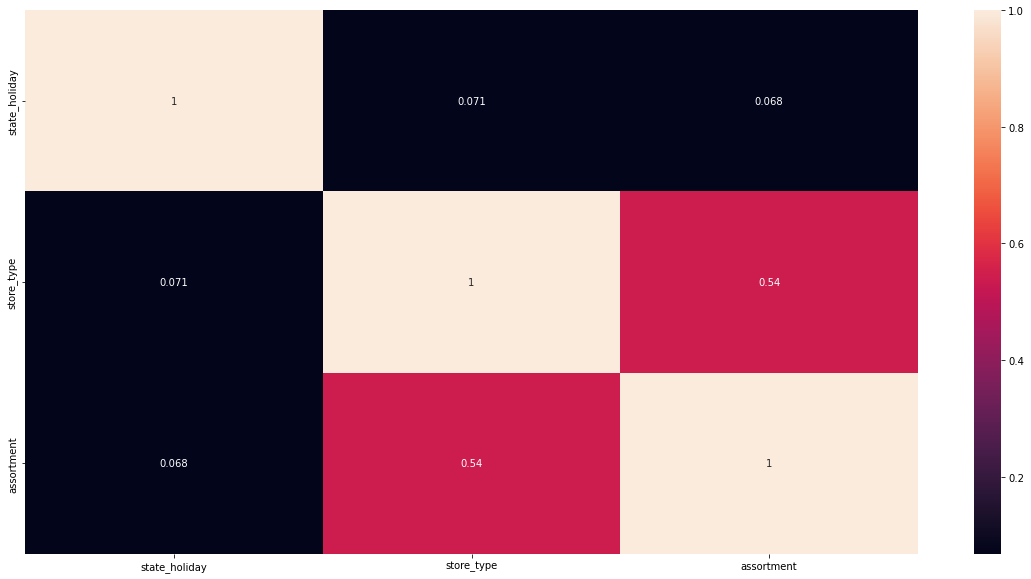

In [47]:

# Cramer é baseado no qui-quadrado - Somente para variável categórica

a = df4.select_dtypes( include="object")

# Calculando v de Cramer 
a1 = cramer_v( a["state_holiday"], a["state_holiday"])
a2 = cramer_v( a["state_holiday"], a["store_type"])
a3 = cramer_v( a["state_holiday"], a["assortment"])

a4 = cramer_v( a["store_type"], a["state_holiday"])
a5 = cramer_v( a["store_type"], a["store_type"])
a6 = cramer_v( a["store_type"], a["assortment"])

a7 = cramer_v( a["assortment"], a["state_holiday"])
a8 = cramer_v( a["assortment"], a["store_type"])
a9 = cramer_v( a["assortment"], a["assortment"])

d = pd.DataFrame({ "state_holiday": [a1,a2,a3], 
                    "store_type": [a4,a5,a6], 
                    "assortment": [a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0. PREPARAÇÃO DOS DADOS

  #### Tipos de Prepação dos dados:
  #### - Normalização: Reescala o centro para 0 com desvio-padrão igual a 1, distribuição Gaussina.
  #### - Reescaling: Reescala para o intervalo entre 0 a 1, distribuição não Gaussina.
  #### - Transformação: Conversão de  variáveis categóricas em numéricas (encoding), transformação de natureza. 

In [48]:
df5 = df4.copy()

## <s>5.1. Normalização</s>

### - Nenhuma variável tem a distribuição normal de acordo com 4.1.2. então vamos utilizar o método de reescaling.

## 5.2. Reescaling

/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

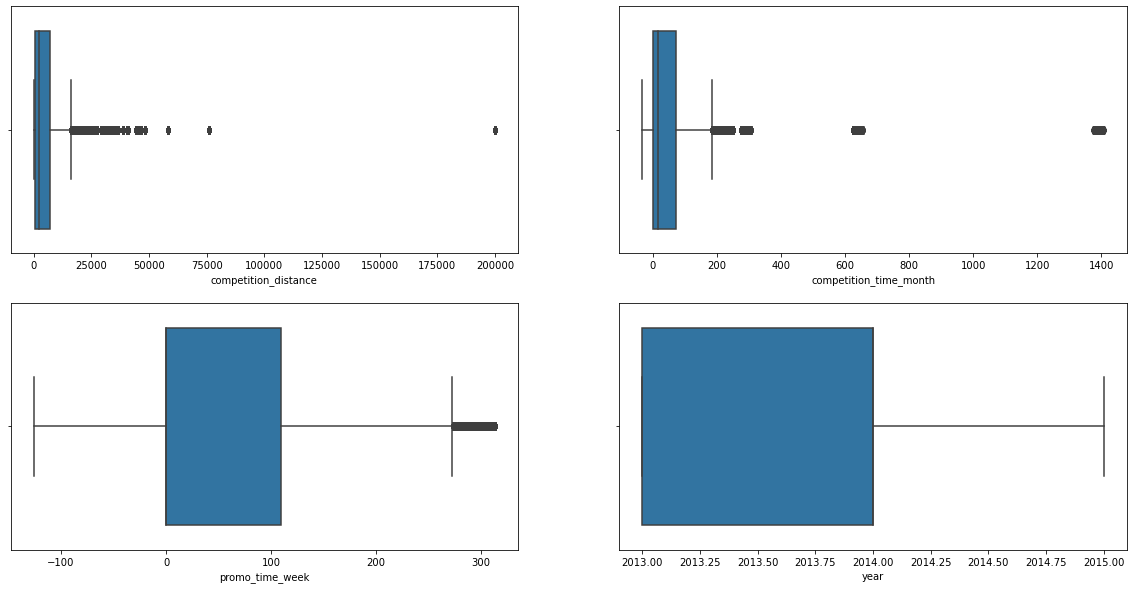

In [49]:
plt.subplot( 2,2,1) 
sns.boxplot(df5["competition_distance"]);

plt.subplot( 2,2,2) 
sns.boxplot(df5["competition_time_month"]);

plt.subplot( 2,2,3) 
sns.boxplot(df5["promo_time_week"]);

plt.subplot( 2,2,4) 
sns.boxplot(df5["year"]);

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance - outliers consideráveis 
df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)

# competition_time_month - outliers consideráveis 
df5["competition_time_month"] = rs.fit_transform(df5[["competition_time_month"]].values)

# promo_time_week - baixa quantidade de outliers 
df5["promo_time_week"] = mms.fit_transform(df5[["promo_time_week"]].values)

# year - sem outliers 
df5["year"] = mms.fit_transform(df5[["year"]].values)



/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

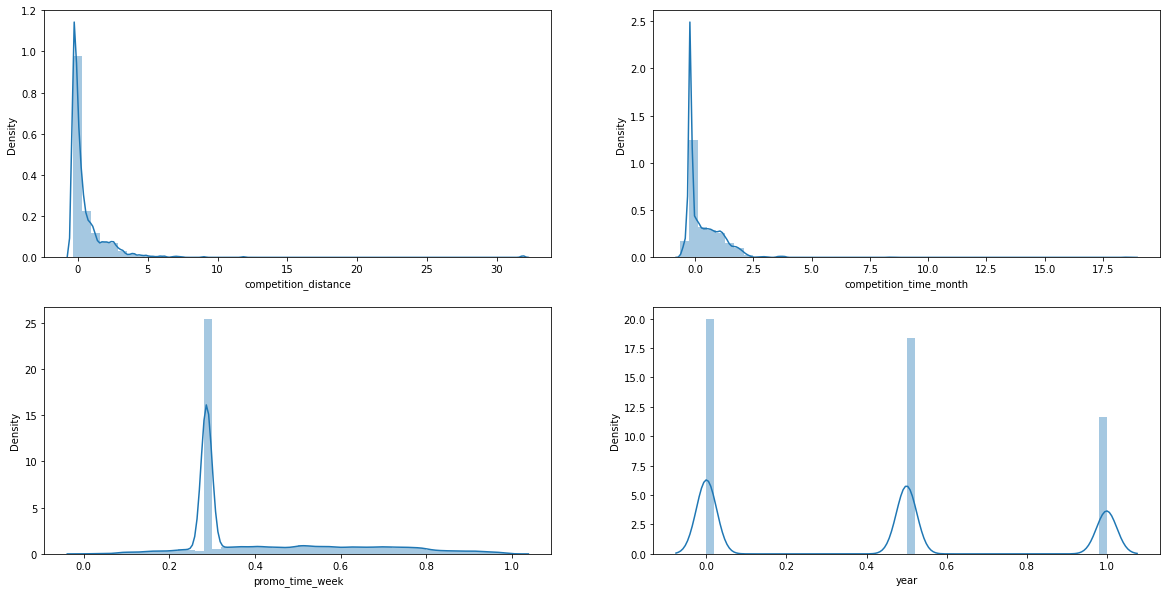

In [51]:
plt.subplot( 2,2,1) 
sns.distplot(df5["competition_distance"]);

plt.subplot( 2,2,2) 
sns.distplot(df5["competition_time_month"]);

plt.subplot( 2,2,3) 
sns.distplot(df5["promo_time_week"]);

plt.subplot( 2,2,4) 
sns.distplot(df5["year"]);


## 5.3. Transformação

### 5.3.1. Encoding (variáveis categóricas)

In [52]:
# state_holiday - One hot Encoding (0 / 1)
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

# store_type - Label Encoding
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])

# assortment - Ordinal encoding
assortment_dict = {"basic":1, "extra":2, "extended":3}
df5["assortment"]= df5["assortment"].map(assortment_dict)

### 5.3.2. Transformação da variável resposta (sales)

/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


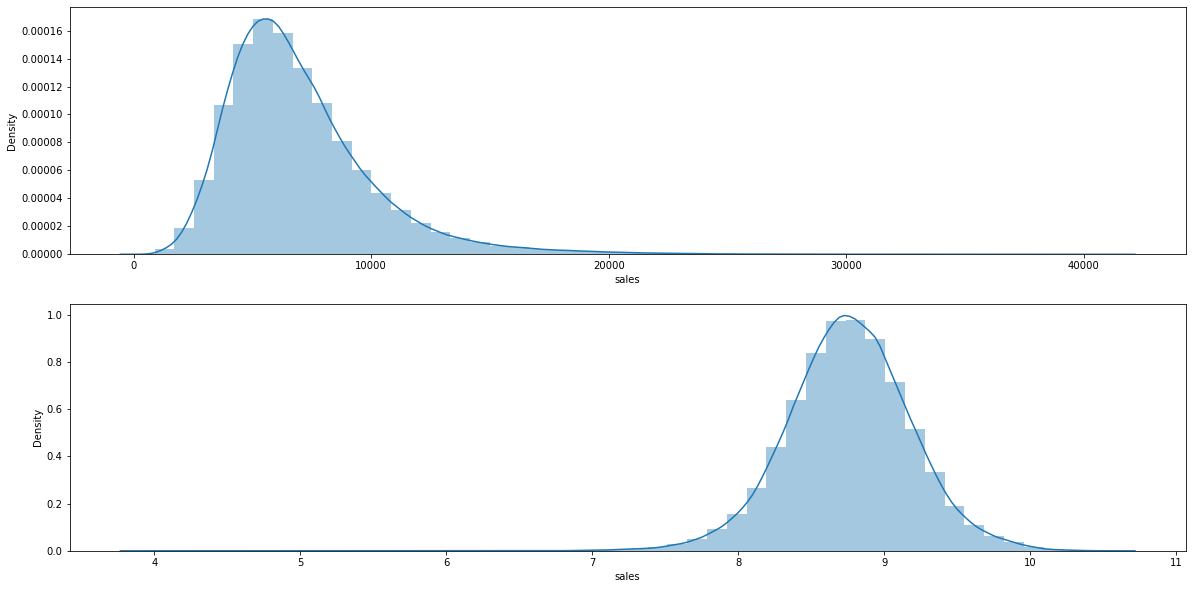

In [53]:
# A transforação logarítimica, transforma a distribuição da variável resposta mais próxima da normal, aplicando o log em todos valores. 
plt.subplot(2,1,1)
sns.distplot(df5["sales"]);

plt.subplot(2,1,2)
df5["sales"] = np.log1p(df5["sales"])
sns.distplot(df5["sales"]);

### 5.3.3. Transformação de natureza

In [54]:
# day_of_week
df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin(x*(2.* np.pi/7)))
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos(x*(2.* np.pi/7)))

# month 
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x*(2.* np.pi/12)))
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x*(2.* np.pi/12)))

# day 
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x*(2.* np.pi/30)))
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x*(2.* np.pi/30)))

# week_of_year
df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin(x*(2.* np.pi/52)))
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos(x*(2.* np.pi/52)))

# 6.0. Seleção de Variáveis

#### Acesse para mais explicação sobre o modelo Boruta: https://tinyurl.com/FeaturesSelection

In [201]:
df6 = df5.copy()

### 6.1. Separando os dados em treino e teste

In [202]:
# deletando as variáveis que foram derivadas em seno e cosseno
cols_drop = ["week_of_year", "day", "month", "day_of_week", "promo_since", "competition_since", "year_week"]
df6 = df6.drop(cols_drop, axis=1)

In [191]:
df6[["store", "date"]].groupby("store").min().reset_index()
print("primeira data do conjunto de treino é em 02/01/2013")

df6[["store", "date"]].groupby("store").max().reset_index()
print("última data do conjunto de treino é em 31/07/2015")

print("\n primeira data:", df6[["store", "date"]].groupby("store").max().reset_index()["date"][0] - datetime.timedelta(days = 6*7)) # pegando as últimas 6 semanas

print("\n antes dessa data serão os dados de treino e após essa data serão os dados de teste")

primeira data do conjunto de treino é em 02/01/2013
última data do conjunto de treino é em 31/07/2015

 primeira data: 2015-06-19 00:00:00

 antes dessa data serão os dados de treino e após essa data serão os dados de teste


In [204]:
# dados de treino
X_train = df6[df6["date"] < "2015-06-19"]
y_train = X_train["sales"]

# dados de test - últimas 6 semanas
X_test = df6[df6["date"] >= "2015-06-19"]
y_test = X_test["sales"]

### 6.2. Usando modelo de seleção Boruta

In [205]:
# dados de treino e teste para o Boruta
X_train_n = X_train.drop(["date", "sales"], axis=1).values
y_train_n = y_train.values.ravel()

In [207]:
# Definir Regressão Random Forest 
rf = RandomForestRegressor(n_jobs=-1)

# Definir Boruta - modelo rodou em 31m 45s (randon_state = mesma aleatoriedade)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Melhores características para Boruta

In [209]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# adicionando colunas 
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MODELOS DE MACHINE LEARNING

In [210]:
x_train = X_train[cols_selected_boruta] # somente variáveis relevantes
x_test = X_test[cols_selected_boruta]

# Time Series 
cols_selected_boruta.extend(feat_to_add)

x_training = X_train[cols_selected_boruta_full] # variáveis relevantes + "date" and "sales"

### 7.1. Modelo de média

In [211]:
# criandio modelo de treino com a variável "sales"
train = x_train.copy() # modelo de treino sem a variável "sales"
train["sales"] = y_train.copy() # modelo de treino com a variável "sales"

test = x_test.copy()
test_sales = y_test.copy() 

# sales average per store on the training period
avg_sales_train = train[["store", "sales"]].groupby("store").mean().reset_index().rename(columns={"sales":"predictions"}) 

# forecast
forecast = pd.merge(test, avg_sales_train, how='left', on="store")
baseline = forecast["predictions"] # sales forecast series

# performance
baseline_result1 = ml_error("Modelo de Média", np.expm1(test_sales), np.expm1(baseline)) #  np.expm1 é pafa desfazer oi log que aplicamos para fazer o modelo. 
baseline_result1

# o modelo que estamos trabalhando não é linear, então o melhor resultado foi com os modelos não lineares 

,Model Name,MAE,MAPE,RMSE
0,Average Model 1,1429.763326,0.216814,1939.32873


### 7.2. Modelo de Regressão Linear

In [216]:
# Modelo
lr = LinearRegression().fit(x_train, y_train)

#Predição
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error("Regressão Linear", np.expm1(y_test), np.expm1(yhat_lr))    
lr_result

,Model Name,MAE,MAPE,RMSE
0,Regressão Linear,1867.089774,0.292694,2671.049215


### 7.3. Modelo de regressão Linear Regularizada - Lasso

In [220]:
# Modelo
lrr = Lasso(alpha=0.00001).fit(x_train, y_train)

#Predição
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error("Regressão Linear - Lasso", np.expm1(y_test), np.expm1(yhat_lrr))    
lrr_result

/Users/joaofmoura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.635e+03, tolerance: 1.455e+01
  model = cd_fast.enet_coordinate_descent(


,Model Name,MAE,MAPE,RMSE
0,Regressão Linear - Lasso,1867.31399,0.292645,2671.8173
